In [1]:
from bs4 import BeautifulSoup
from random import randint, shuffle
from time import sleep
import re
import pandas as pd
import json
import math
import requests
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
import os
from tqdm import tqdm_notebook as tqdm
import shutil
import numpy as np
import pandas_profiling
import pickle

pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", -1)
pd.set_option("display.float_format", "{:,.4f}".format)
pd.set_option("display.max_info_rows", 200)


import surprise
from surprise.model_selection import train_test_split
from surprise import NormalPredictor
from surprise import Dataset
from surprise import Reader
from surprise import accuracy
from surprise.model_selection import cross_validate
from surprise.prediction_algorithms import SVD, SVDpp, BaselineOnly, NMF, CoClustering
from surprise.prediction_algorithms import KNNWithMeans, KNNBasic, KNNBaseline
from surprise.model_selection import GridSearchCV

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")
sns.set_context("paper", font_scale=1.8)
sns.set_palette("hls", 15)

# Dataset

In [18]:
# List of all products from Sephora as of June 24 with binary columns for categories

products = pd.read_csv("df_sephora.csv")
products.head(1)

,id,name,brand_id,brand_name,short_desc,long_desc,item,item_name,list_price,variation,variants,price_low,price_high,is_limited_edition,rating,review_count,user_favorites,categories,url,image_url,ingredients,suggested_usage,brand_long,has_variants,has_categories,has_ingredients,has_suggested_usage,is_rated,cologne,men,fragrance,perfume,women,lotions_and_oils,rollerballs_and_travel_size,perfume_gift_sets,value_and_gift_sets,lipstick,lip,makeup,lip_balms_and_treatments,lip_treatments,mascara,eye,lip_gloss,eyebrow,body_sprays_and_deodorant,bath_and_shower,cologne_gift_sets,body_mist_and_hair_mist,concealer,face,lip_stain,deodorant_and_antiperspirant,body_care,bath_and_body,face_primer,foundation,tinted_moisturizer,face_serums,treatments,skincare,mists_and_essences,moisturizers,highlighter,liquid_lipstick,lip_sets,face_sets,setting_spray_and_powder,aftershave,shaving,eye_creams_and_treatments,eye_care,face_masks,masks,face_wash_and_cleansers,cleansers,exfoliators,makeup_removers,eyeliner,face_brushes,makeup_brushes_and_applicators,makeup_palettes,eye_palettes,bb_and_cc_creams,blush,cheek,facial_peels,eyelash_curlers,accessories,eye_sets,mini_size,bronzer,face_oils,contour,lip_liner,eyeshadow,face_wash,moisturizer_and_treatments,toners,body_lotions_and_body_oils,body_moisturizers,scrub_and_exfoliants,self_tanners,face_sunscreen,sun_care,blemish_and_acne_treatments,facial_cleansing_brushes,high_tech_tools,for_face,color_correct,skincare_sets,decollete_and_neck_creams,hand_cream_and_foot_cream,candles_and_home_scents,night_creams,sheet_masks,eye_brushes,beauty_supplements,wellness,facial_rollers,body_sunscreen,cellulite_and_stretch_marks,for_body,body_wash_and_shower_gel,nail,other_needs,shampoo_and_conditioner,hair,hair_styling_and_treatments,conditioner,shampoo,eye_masks,eye_primer,mirrors_and_sharpeners,tools_and_brushes,cheek_palettes,face_wipes,tweezers_and_eyebrow_tools,hair_accessories,hair_tools,gift_cards,false_eyelashes,brush_sets,brush_cleaners,makeup_and_travel_cases,hair_removal,lip_brushes,sponges_and_applicators,makeup_bags_and_travel_cases,hair_masks,curling_irons,hair_straighteners_and_flat_irons,hair_dryers,dry_shampoo,hair_brushes_and_combs,scalp_and_hair_treatments,bath_soaks_and_bubble_bath,hair_styling_products,blotting_papers,hair_primers,hair_oil,teeth_whitening,anti_aging,travel_size,facial_men,candles,diffusers,holistic_wellness,leave_in_conditioner,hair_spray,color_care,best_for,just_arrived,gifts_her,gifts_men,gifts_them,gifts_teens,gift_sets_men,gift_sets,editors_picks,luxury_gifts,sephora_exclusives,perfume_men,grooming_men,hair_men,personal_care_men,just_arrived_men,best_seller_men,vegan,cruelty_free,for_men
0,P180726,Pour Homme II,1063,Gucci,"An alluring fragrance heightened by a sensual, spicy soul, Gucci Pour Homme II is the essence of young, masculine sensuality.","An alluring fragrance heightened by a sensual, spicy soul, Gucci Pour Homme II is the essence of young, masculine sensuality. The embodiment of relaxed refinement for the modern-minded man whose style is distinctive and effortless, this fresh, spicy, woody, scent is filled with playful attitude and charisma. Notes: Bergamot, Violet Leaves, Cinnamon, Pimento, Black Tea, Myrrh, Tobacco Leaves, White Musk, Olive Wood. Style: Seductive. Masculine. Free-spirited.",997338,3.3 oz/ 98 mL Eau de Toilette Spray,92.0000,Size + Concentration + Formulation,NaN,92.0000,92.0000,0,4.8070,114,2030,"{'cat60150': 'Cologne', 'cat1230040': 'Men', 'cat160006': 'Fragrance'}",https://www.sephora.com/product/pour-homme-ii-P180726?skuId=997338,https://www.sephora.com/productimages/sku/s997338-main-zoom.jpg,"Alcohol Denat., Fragrance, Water, Ethylhexyl Methoxycinnamate, Diethylamino Hydroxybenzoyl Hexyl Benzoate, BHT, Benzyl Salicylate, Linalool, Butylphenyl Methylpropional, Hydroxycitronellal, Limonene, Hexyl Cinnamal, Citronellol, Alpha-Isomethyl Ionone, Geraniol, Hydroxyisohexyl 3-Cyclohexene Carboxaldehyde, Citral, Farnesol, Isoeugenol, Anise Alcohol, Benzyl Ben

In [239]:
products.info(null_counts=True, max_cols=200)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9007 entries, 0 to 9006
Data columns (total 193 columns):
id                                   9007 non-null object
name                                 9007 non-null object
brand_id                             9007 non-null int64
brand_name                           9007 non-null object
short_desc                           8997 non-null object
long_desc                            8997 non-null object
item                                 9007 non-null int64
item_name                            7696 non-null object
list_price                           9007 non-null float64
variation                            9007 non-null object
variants                             3930 non-null object
price_low                            9007 non-null float64
price_high                           9007 non-null float64
is_limited_edition                   9007 non-null int64
is_natural_organic                   9007 non-null int64
rating                 

In [154]:
# Product reviews for the past 2 years where users recommended and rated the product 3 or above.

product_reviews = pd.read_csv("selected_reviews_short2.csv")
product_reviews

/Applications/anaconda3/envs/learn-env/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,product_id,author_id,date,review_id,rating,helpfulness,feedback_count,positive_feedback,negative_feedback,comment_count,review_title,review_text,skintype,eyecolor,skinconcerns,staffcontext,haircolor,skintone,incentivizedreview,verifiedpurchaser,age,hairconcerns,haircondition
0,P0417,5869746961,2019-09-14 17:16:59+00:00,135835739,3,0.67,3,2,1,0,NaN,"It doesn't help with blackheads at all, but it does with whiteheads. It is okay",combination,green,acne,False,brunette,light,False,NaN,NaN,NaN,NaN
1,P0417,22189528930,2019-07-07 17:48:13+00:00,130283148,3,1.00,5,5,0,0,NaN,"Be careful using this, it does extract pimples but only if they are at a head and ready to pop. Otherwise the harder you push to bring it out marks your skin. It’s better than using your nails and bruising your skin on stubborn pimples but still can damage your skin. The black head extractor does work fantastic, brings out the really stubborn black heads but then again also damages your skin if your press too hard. Trail and error learning how hard to press before making marks.",combination,blue,acne,False,black,medium,False,NaN,NaN,NaN,NaN
2,P0417,5641704837,2018-09-15 16:34:33+00:00,118730320,3,2.00,0,0,0,0,NaN,It works but I think it’s not as gentle as I would like. It can still cause trauma on your skin. So be gentle! Better than using your fingers.,combination,blue,acne,NaN,red,fair,NaN,NaN,NaN,NaN,NaN
3,P04546871,22081371793,2020-05-17 18:17:18+00:00,156485522,3,1.00,3,3,0,0,"She’s cute, glitter will get on your clothing",Bought this on sale and used it for a shoot at home. It’s super cute and feels very nice with amazing sparkle pay off in the light. Highly recommend using a body brush for this just to avoid it being clustered in your hands. The glitter will get on everything you touch your skin on as a heads up. Great for warm outings to amp your look.,combination,brown,acne,False,brunette,medium,False,NaN,NaN,NaN,NaN
4,P04546871,1440172327,2019-11-12 01:50:25+00:00,138255643,3,2.00,0,0,0,0,Beautiful but Sticky,The pay off the glitter is absolutely beautiful but it’s sticky. That is why I didn’t give this 4 stars.,combination,brown,aging,False,blonde,light,False,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
899987,P99902,6041243828,2019-04-26 01:14:25+00:00,127314904,5,2.00,0,0,0,0,NaN,Love this Eyeliner. Stays in place,oily,hazel,NaN,False,brunette,light,False,NaN,NaN,NaN,NaN
899988,P99902,1334062044,2019-04-26 00:31:45+00:00,127313503,5,1.00,2,2,0,0,The only eyeliner you should own,"If you want a Truly Good Eyeliner buy this. Here is why I will only buy this brand and type of eyeliner 1. It doesnt irritate my eyes and cause eye boogers when using it on my waterline 2. It does NoT run. 3. It glides on without having to tug 4. It comes with a smudger at the end 5. It goes on properly the first time and if you want it extra thick, you can put it on another layer without causing that weird skipping effect. Yes it is absurdly expensive, but I dont have time for drama and problems when I am getting ready for work. It is worth it. Get it, but only get this one.",combination,NaN,NaN,False,black,olive,False,NaN,NaN,NaN,NaN
899989,P99902,5649540,2018-10-13 05:25:38+00:00,120021816,5,1.00,14,14,0,0,A must for an eyeliner that STAYS on!!!,"I am so highly impressed at this waterproof liner that I had to post about it.\nI lost my son in April and well, I cry a lot. I haven't been out much lately when when I do go out I use this liner since it is truly indelible like ink! I remove it with an oil based remover for bet removal. I get complements [I'm older too]. The Intense Brown and Captivating Blue is quite beautiful on eyes even over the black or brown..unlike all my others these just work and look best. I have a purple/plum shade not shown here plus more not seen on here but in teh stores are gorgeous on. There is a short smudge time after lining but it's so worth it. I own maybe 50 liners lol mid to 

In [155]:
product_reviews.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 899992 entries, 0 to 899991
Data columns (total 23 columns):
product_id            899992 non-null object
author_id             899992 non-null object
date                  899992 non-null object
review_id             899992 non-null int64
rating                899992 non-null int64
helpfulness           899992 non-null float64
feedback_count        899992 non-null int64
positive_feedback     899992 non-null int64
negative_feedback     899992 non-null int64
comment_count         899992 non-null int64
review_title          600845 non-null object
review_text           895058 non-null object
skintype              888914 non-null object
eyecolor              872991 non-null object
skinconcerns          523567 non-null object
staffcontext          623709 non-null object
haircolor             882991 non-null object
skintone              888803 non-null object
incentivizedreview    623709 non-null object
verifiedpurchaser     233798 non-null o

In [152]:
# product_reviews = product_reviews[product_reviews.helpfulness>=0.5].copy()

In [153]:
# product_reviews.to_csv("selected_reviews_short2.csv", index=False)

## User

In [156]:
user_stats = product_reviews[[
    "author_id","review_id", "age", "skintone", "skintype", "skinconcerns",
    "eyecolor", "haircolor", "haircondition", "hairconcerns"
]].copy()
user_stats.shape

(899992, 10)

In [157]:
user_stats.fillna('0', inplace=True)

In [158]:
user_stats = user_stats.sort_values(["age", "skintone", "skintype", "skinconcerns", "eyecolor",
            "haircolor", "haircondition", "hairconcerns"]).copy()
user_stats.reset_index(drop=True, inplace=True)
user_stats

,author_id,review_id,age,skintone,skintype,skinconcerns,eyecolor,haircolor,haircondition,hairconcerns
0,23023065402,135995852,0,0,0,0,0,0,0,0
1,1886707486,121310090,0,0,0,0,0,0,0,0
2,5372680671,137239442,0,0,0,0,0,0,0,0
3,10612140468,151499522,0,0,0,0,0,0,0,0
4,5742906597,126741502,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
899987,2489107310,125474925,over54,tan,oily,darkCircles,brown,black,0,0
899988,26041356151,156235741,over54,tan,oily,sunDamage,brown,blonde,0,0
899989,26041356151,157559217,over54,tan,oily,sunDamage,brown,blonde,0,0
899990,26041356151,157314489,over54,tan,oily,sunDamage,brown,blonde,0,Volumizing


In [183]:
unique_id = user_stats[user_stats.duplicated(subset=["age", "skintone", "skintype", "skinconcerns", "eyecolor",
            "haircolor", "haircondition", "hairconcerns"], keep="first")==False].index

unique_id

Int64Index([     0,   7316,   7321,   7331,   7338,   7353,   7361,   7363,
              7365,   7366,
            ...
            899968, 899969, 899970, 899971, 899975, 899982, 899984, 899988,
            899990, 899991],
           dtype='int64', length=45725)

In [184]:
for i in tqdm(unique_id):
    user_stats.at[i, "uid"] = "_".join(
        list(user_stats[[
            "age", "skintone", "skintype", "skinconcerns", "eyecolor",
            "haircolor", "haircondition", "hairconcerns"
        ]].iloc[i].values))
    
user_stats

,author_id,review_id,age,skintone,skintype,skinconcerns,eyecolor,haircolor,haircondition,hairconcerns,uid
0,23023065402,135995852,0,0,0,0,0,0,0,0,0_0_0_0_0_0_0_0
1,1886707486,121310090,0,0,0,0,0,0,0,0,NaN
2,5372680671,137239442,0,0,0,0,0,0,0,0,NaN
3,10612140468,151499522,0,0,0,0,0,0,0,0,NaN
4,5742906597,126741502,0,0,0,0,0,0,0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...
899987,2489107310,125474925,over54,tan,oily,darkCircles,brown,black,0,0,NaN
899988,26041356151,156235741,over54,tan,oily,sunDamage,brown,blonde,0,0,over54_tan_oily_sunDamage_brown_blonde_0_0
899989,26041356151,157559217,over54,tan,oily,sunDamage,brown,blonde,0,0,NaN
899990,26041356151,157314489,over54,tan,oily,sunDamage,brown,blonde,0,Volumizing,over54_tan_oily_sunDamage_brown_blonde_0_Volumizing


In [185]:
user_stats.uid.fillna(method="ffill", inplace=True)

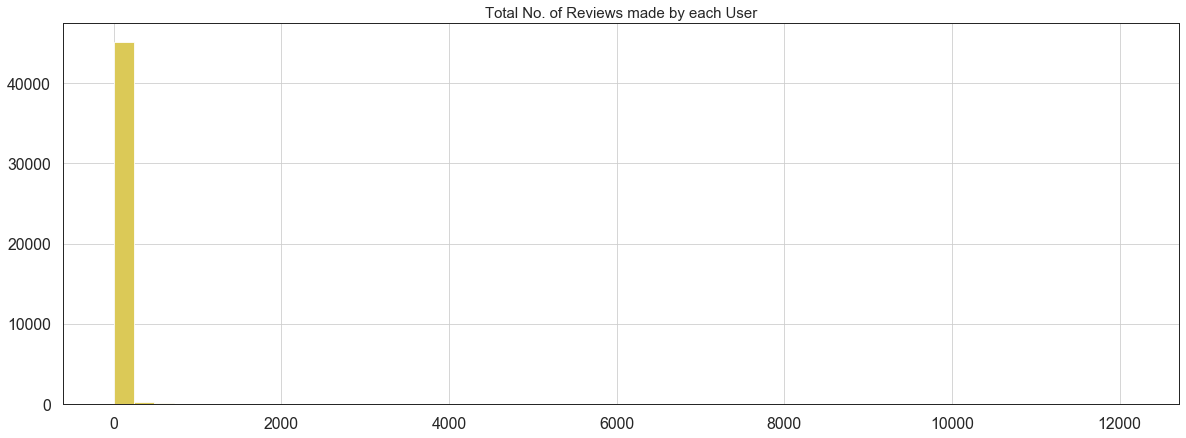

In [204]:
plt.figure(figsize=(20, 7))
user_stats.groupby("uid").count().review_id.hist(bins = 50, color="C2")
plt.title("Total No. of Reviews made by each User", fontsize=15)
plt.show()

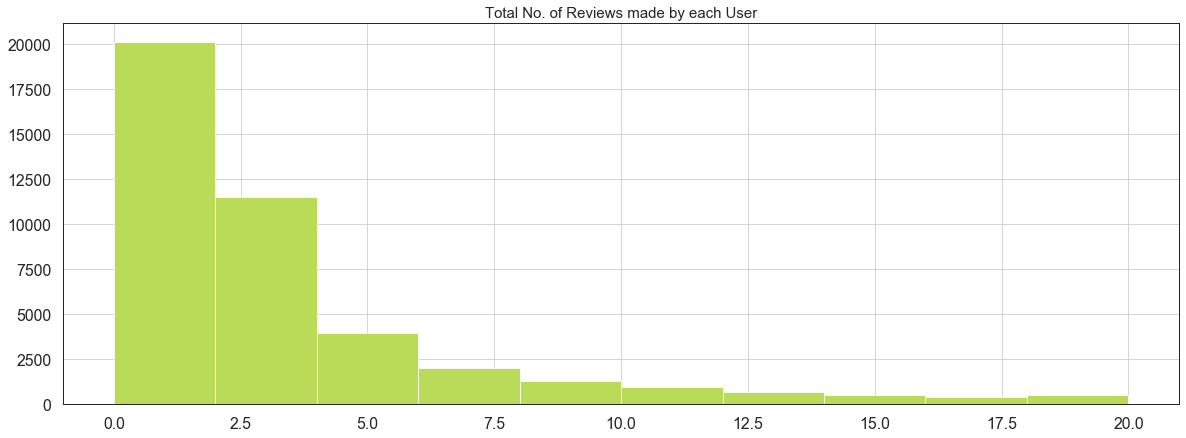

In [205]:
plt.figure(figsize=(20, 7))
user_stats.groupby("uid").count().review_id.hist(bins = 10, range=(0,20), color="C3")
plt.title("Total No. of Reviews made by each User", fontsize=15)
plt.show()

# a sharp decline in number of reviews made by each unique user 1

In [188]:
user_stats.groupby("uid").count().reset_index().iloc[:, :2].groupby(
    "author_id").count().sort_values("uid", ascending=False).head(5)

,uid
author_id,
1,20143
2,7707
3,3803
4,2419
5,1522


In [189]:
uid_to_keep = user_stats.groupby("uid").count().iloc[:,:1].reset_index()
uid_to_keep = list(uid_to_keep[uid_to_keep.author_id>=2].uid.unique())
uid_to_keep

['0_0_0_0_0_0_0_0',
 '0_0_0_0_0_0_0_AntiAging',
 '0_0_0_0_0_0_0_ColorProtection',
 '0_0_0_0_0_0_0_CurlyEnhancing',
 '0_0_0_0_0_0_0_Damage',
 '0_0_0_0_0_0_0_Frizz',
 '0_0_0_0_0_0_0_HeatProtection',
 '0_0_0_0_0_0_0_Oiliness',
 '0_0_0_0_0_0_chemicallyTreated_0',
 '0_0_0_0_0_0_chemicallyTreated_ColorProtection',
 '0_0_0_0_0_0_chemicallyTreated_Damage',
 '0_0_0_0_0_0_curly_Frizz',
 '0_0_0_0_0_0_fine_0',
 '0_0_0_0_0_0_fine_Damage',
 '0_0_0_0_0_0_straight_0',
 '0_0_0_0_0_0_wavy_0',
 '0_0_0_0_0_auburn_0_0',
 '0_0_0_0_0_auburn_0_ColorProtection',
 '0_0_0_0_0_auburn_chemicallyTreated_0',
 '0_0_0_0_0_black_0_0',
 '0_0_0_0_0_black_0_ColorProtection',
 '0_0_0_0_0_black_0_CurlyEnhancing',
 '0_0_0_0_0_black_0_Damage',
 '0_0_0_0_0_black_0_Dandruff',
 '0_0_0_0_0_black_0_Frizz',
 '0_0_0_0_0_black_0_Oiliness',
 '0_0_0_0_0_black_0_Thinning',
 '0_0_0_0_0_black_0_Volumizing',
 '0_0_0_0_0_black_coarse_0',
 '0_0_0_0_0_black_curly_0',
 '0_0_0_0_0_blonde_0_0',
 '0_0_0_0_0_blonde_0_AntiAging',
 '0_0_0_0_0_blonde

In [284]:
author_uid = user_stats[user_stats.uid.isin(uid_to_keep)][["author_id", "uid"]].copy()
author_uid.drop_duplicates(keep="first", inplace=True)
author_uid.reset_index(drop=True, inplace=True)
author_uid.sort_values(["author_id", "uid"], ascending=False)

,author_id,uid
338661,orderGen569553,0_medium_combination_0_hazel_brunette_0_AntiAging
338513,orderGen569553,0_medium_combination_0_hazel_brunette_0_0
147052,orderGen5563740,0_fair_normal_aging_brown_gray_0_0
146637,orderGen5563740,0_fair_normal_aging_brown_brunette_0_0
316788,orderGen51156,0_medium_combination_0_brown_black_0_0
...,...,...
71373,582399,0_fair_combination_0_hazel_brunette_0_0
508050,580450,0_porcelain_oily_acne_brown_auburn_0_Frizz
109261,540904,0_fair_combination_redness_blue_brunette_0_0
120337,539986,0_fair_dry_0_hazel_brunette_0_Frizz


In [191]:
author_uid_rating = pd.merge(
    product_reviews[["author_id", "rating"]],
    author_uid,
    how="left",
    on="author_id").groupby("uid").mean().reset_index()
author_uid_rating = pd.merge(
    author_uid_rating,
    user_stats.groupby("uid").count().reset_index()[["uid", "review_id"]],
    how="left",
    on="uid")
author_uid_rating

,uid,rating,review_id
0,0_0_0_0_0_0_0_0,4.73,7316
1,0_0_0_0_0_0_0_AntiAging,4.89,5
2,0_0_0_0_0_0_0_ColorProtection,4.90,10
3,0_0_0_0_0_0_0_CurlyEnhancing,4.71,7
4,0_0_0_0_0_0_0_Damage,4.85,15
...,...,...,...
25577,over54_tan_oily_blackheads_brown_black_0_0,4.60,4
25578,over54_tan_oily_blackheads_brown_brunette_0_0,4.79,7
25579,over54_tan_oily_blackheads_brown_gray_0_0,4.58,2
25580,over54_tan_oily_darkCircles_brown_black_0_0,4.25,4


In [238]:
author_uid.to_csv("author_uid.csv", index=False)
author_uid_rating.to_csv("author_uid_rating.csv", index=False)
user_stats.to_csv("userstats.csv", index=False)

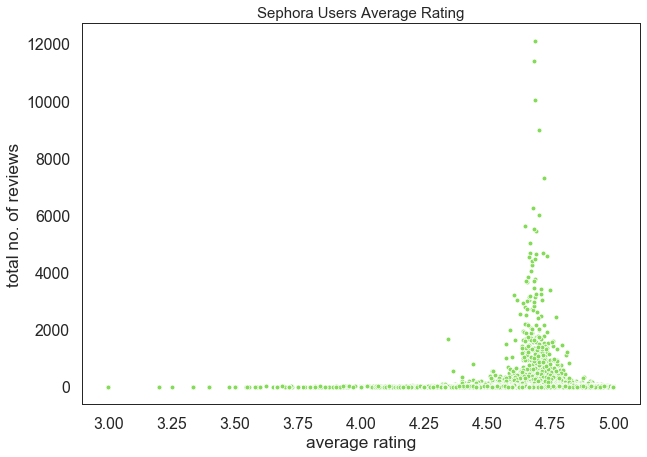

In [206]:
plt.figure(figsize=(10, 7))
sns.scatterplot("rating", "review_id", data=author_uid_rating,
                  color="C4")
plt.xlabel("average rating")
plt.ylabel("total no. of reviews")
plt.title("Sephora Users Average Rating", fontsize=15)
plt.show()

# reviews for the past 2 years
# where users have at least 2 reviews
# user rating >= 3
# and user recommended the product

## Item

In [244]:
product_stats = product_reviews[product_reviews.author_id.isin(author_uid.author_id)][[
    "product_id", "rating", "age", "skintone", "skintype", "skinconcerns",
    "eyecolor", "haircolor", "haircondition", "hairconcerns"
]].copy()
product_stats.shape

(889171, 10)

In [245]:
for col in product_stats.columns[1:]:
    print(col)
    print(product_stats[col].unique(),"\n")

rating
[3 4 5] 

age
[nan '13to17' '35to44' '18to24' '25to34' '45to54' 'over54'] 

skintone
['light' 'medium' 'fair' 'ebony' 'olive' 'deep' 'dark' 'tan' 'porcelain'
 nan] 

skintype
['combination' 'oily' 'normal' 'dry' nan] 

skinconcerns
['acne' 'aging' 'blackheads' nan 'unevenSkinTones' 'sensitivity'
 'darkCircles' 'calluses' 'pores' 'redness' 'dullness' 'cellulite'
 'sunDamage' 'cuticles' 'stretchMarks' 'puffiness'] 

eyecolor
['green' 'blue' 'brown' 'hazel' nan 'gray'] 

haircolor
['brunette' 'black' 'red' 'blonde' 'gray' nan 'auburn'] 

haircondition
[nan 'chemicallyTreated' 'normal' 'wavy' 'fine' 'curly' 'coarse' 'dry'
 'oily' 'straight'] 

hairconcerns
[nan 'ColorProtection' 'Damage' 'CurlyEnhancing' 'Dandruff' 'Volumizing'
 'AntiAging' 'Frizz' 'Hold' 'Thinning' 'Oiliness' 'StraighteningSmoothing'
 'HeatProtection' 'Shine'] 



In [246]:
product_stats = pd.get_dummies(product_stats,
                          columns=product_stats.columns[1:])
product_stats.columns = [col.lower() for col in product_stats.columns]

In [247]:
product_stats = product_stats.groupby("product_id").sum().reset_index()
product_stats

,product_id,rating_3,rating_4,rating_5,age_13to17,age_18to24,age_25to34,age_35to44,age_45to54,age_over54,skintone_dark,skintone_deep,skintone_ebony,skintone_fair,skintone_light,skintone_medium,skintone_olive,skintone_porcelain,skintone_tan,skintype_combination,skintype_dry,skintype_normal,skintype_oily,skinconcerns_acne,skinconcerns_aging,skinconcerns_blackheads,skinconcerns_calluses,skinconcerns_cellulite,skinconcerns_cuticles,skinconcerns_darkcircles,skinconcerns_dullness,skinconcerns_pores,skinconcerns_puffiness,skinconcerns_redness,skinconcerns_sensitivity,skinconcerns_stretchmarks,skinconcerns_sundamage,skinconcerns_unevenskintones,eyecolor_blue,eyecolor_brown,eyecolor_gray,eyecolor_green,eyecolor_hazel,haircolor_auburn,haircolor_black,haircolor_blonde,haircolor_brunette,haircolor_gray,haircolor_red,haircondition_chemicallytreated,haircondition_coarse,haircondition_curly,haircondition_dry,haircondition_fine,haircondition_normal,haircondition_oily,haircondition_straight,haircondition_wavy,hairconcerns_antiaging,hairconcerns_colorprotection,hairconcerns_curlyenhancing,hairconcerns_damage,hairconcerns_dandruff,hairconcerns_frizz,hairconcerns_heatprotection,hairconcerns_hold,hairconcerns_oiliness,hairconcerns_shine,hairconcerns_straighteningsmoothing,hairconcerns_thinning,hairconcerns_volumizing
0,P0417,3.00,5.00,14.00,0.00,0.00,1.00,0.00,0.00,0.00,2.00,0.00,1.00,5.00,3.00,3.00,2.00,4.00,0.00,12.00,0.00,0.00,7.00,12.00,4.00,2.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,4.00,11.00,0.00,3.00,1.00,1.00,5.00,2.00,9.00,0.00,2.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,P04546871,13.00,48.00,201.00,2.00,1.00,12.00,8.00,0.00,5.00,39.00,43.00,14.00,25.00,45.00,32.00,24.00,15.00,23.00,131.00,31.00,46.00,50.00,101.00,47.00,23.00,0.00,1.00,1.00,18.00,8.00,4.00,0.00,4.00,10.00,1.00,0.00,1.00,27.00,182.00,1.00,22.00,22.00,9.00,89.00,45.00,108.00,0.00,4.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,P04897543,23.00,100.00,467.00,7.00,14.00,24.00,8.00,2.00,10.00,38.00,60.00,13.00,96.00,113.00,125.00,44.00,39.00,56.00,326.00,65.00,66.00,126.00,256.00,79.00,67.00,0.00,12.00,1.00,48.00,15.00,2.00,0.00,15.00,11.00,2.00,2.00,7.00,74.00,374.00,4.00,63.00,55.00,25.00,171.00,104.00,249.00,7.00,18.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,P0771,0.00,0.00,3.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,3.00,0.00,0.00,0.00,1.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,1.00,0.00,0.00,2.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,P0782,0.00,1.00,5.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,2.00,2.00,1.00,0.00,0.00,3.00,1.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,2.00,0.00,2.00,1.00,1.00,0.00,3.00,2.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8509,P9940,2.00,8.00,34.00,0.00,0.00,5.00,0.00,0.00,1.00,0.00,1.00,0.00,12.00,16.00,6.00,1.00,4.00,4.00,24.00,6.00,11.00,3.00,18.00,11.00,4.00,0.00,0.00,1.00,2.00,1.00,0.00,0.00,0.00,2.00,0.00,0.00,0.00,10.00,21.00,0.00,6.00,6.00,2.00,10.00,11.00,18.00,0.00,3.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
8510,P9941,4.00,10.00,57.00,1.00,2.00,2.00,1.00,1.00,1.00,3.00,5.00,1.00,11.00,16.00,17.00,6.00,5.00,7.00,47.00,5.00,9.00,10.00,32.00,18.0

In [248]:
product_stats["total_reviews"] = product_stats["rating_3"] + product_stats[
    "rating_4"] + product_stats["rating_5"]

In [249]:
# product_stats.to_csv("productstats.csv",index=False)

In [209]:
product_stats = pd.read_csv("productstats.csv")

In [250]:
product_stats_percentage = product_stats.copy()

In [251]:
del product_stats

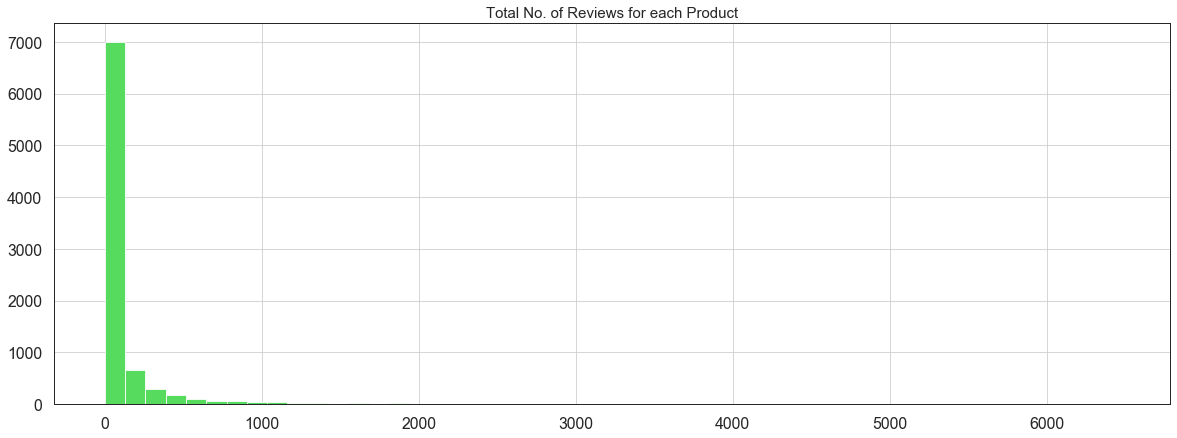

In [252]:
plt.figure(figsize=(20, 7))
product_stats_percentage.total_reviews.hist(bins = 50, color="C5")
plt.title("Total No. of Reviews for each Product", fontsize=15)
plt.show()

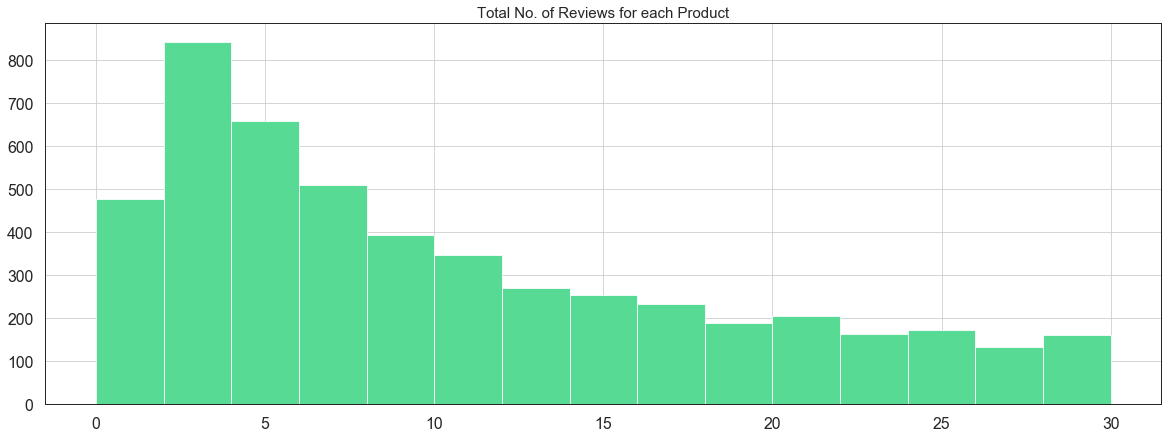

In [263]:
plt.figure(figsize=(20, 7))
product_stats_percentage.total_reviews.hist(bins = 15, range=(0,30), color="C6")
plt.title("Total No. of Reviews for each Product", fontsize=15)
plt.show()

# a sharp decline in number of reviews from 4/5

In [254]:
product_stats_percentage[product_stats_percentage.total_reviews <= 15].groupby("total_reviews").count().iloc[:,:1]

,product_id
total_reviews,
1.00,478
2.00,444
3.00,399
4.00,354
5.00,305
6.00,277
7.00,233
8.00,214
9.00,180


In [264]:
product_stats_percentage = product_stats_percentage[product_stats_percentage.total_reviews >=5].reset_index(drop=True)
product_stats_percentage

,product_id,rating_3,rating_4,rating_5,age_13to17,age_18to24,age_25to34,age_35to44,age_45to54,age_over54,skintone_dark,skintone_deep,skintone_ebony,skintone_fair,skintone_light,skintone_medium,skintone_olive,skintone_porcelain,skintone_tan,skintype_combination,skintype_dry,skintype_normal,skintype_oily,skinconcerns_acne,skinconcerns_aging,skinconcerns_blackheads,skinconcerns_calluses,skinconcerns_cellulite,skinconcerns_cuticles,skinconcerns_darkcircles,skinconcerns_dullness,skinconcerns_pores,skinconcerns_puffiness,skinconcerns_redness,skinconcerns_sensitivity,skinconcerns_stretchmarks,skinconcerns_sundamage,skinconcerns_unevenskintones,eyecolor_blue,eyecolor_brown,eyecolor_gray,eyecolor_green,eyecolor_hazel,haircolor_auburn,haircolor_black,haircolor_blonde,haircolor_brunette,haircolor_gray,haircolor_red,haircondition_chemicallytreated,haircondition_coarse,haircondition_curly,haircondition_dry,haircondition_fine,haircondition_normal,haircondition_oily,haircondition_straight,haircondition_wavy,hairconcerns_antiaging,hairconcerns_colorprotection,hairconcerns_curlyenhancing,hairconcerns_damage,hairconcerns_dandruff,hairconcerns_frizz,hairconcerns_heatprotection,hairconcerns_hold,hairconcerns_oiliness,hairconcerns_shine,hairconcerns_straighteningsmoothing,hairconcerns_thinning,hairconcerns_volumizing,total_reviews
0,P0417,3.00,5.00,14.00,0.00,0.00,1.00,0.00,0.00,0.00,2.00,0.00,1.00,5.00,3.00,3.00,2.00,4.00,0.00,12.00,0.00,0.00,7.00,12.00,4.00,2.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,4.00,11.00,0.00,3.00,1.00,1.00,5.00,2.00,9.00,0.00,2.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,22.00
1,P04546871,13.00,48.00,201.00,2.00,1.00,12.00,8.00,0.00,5.00,39.00,43.00,14.00,25.00,45.00,32.00,24.00,15.00,23.00,131.00,31.00,46.00,50.00,101.00,47.00,23.00,0.00,1.00,1.00,18.00,8.00,4.00,0.00,4.00,10.00,1.00,0.00,1.00,27.00,182.00,1.00,22.00,22.00,9.00,89.00,45.00,108.00,0.00,4.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,262.00
2,P04897543,23.00,100.00,467.00,7.00,14.00,24.00,8.00,2.00,10.00,38.00,60.00,13.00,96.00,113.00,125.00,44.00,39.00,56.00,326.00,65.00,66.00,126.00,256.00,79.00,67.00,0.00,12.00,1.00,48.00,15.00,2.00,0.00,15.00,11.00,2.00,2.00,7.00,74.00,374.00,4.00,63.00,55.00,25.00,171.00,104.00,249.00,7.00,18.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,590.00
3,P0782,0.00,1.00,5.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,2.00,2.00,1.00,0.00,0.00,3.00,1.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,2.00,0.00,2.00,1.00,1.00,0.00,3.00,2.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,6.00
4,P0847,0.00,1.00,6.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,4.00,2.00,0.00,0.00,1.00,4.00,2.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,4.00,0.00,0.00,2.00,0.00,2.00,1.00,2.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,7.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6834,P9940,2.00,8.00,34.00,0.00,0.00,5.00,0.00,0.00,1.00,0.00,1.00,0.00,12.00,16.00,6.00,1.00,4.00,4.00,24.00,6.00,11.00,3.00,18.00,11.00,4.00,0.00,0.00,1.00,2.00,1.00,0.00,0.00,0.00,2.00,0.00,0.00,0.00,10.00,21.00,0.00,6.00,6.00,2.00,10.00,11.00,18.00,0.00,3.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,44.00
6835,P9941,4.00,10.00,57.00,1.00,2.00,2.00,1.00,1.00,1.00,3.00,5.00,1.00,11.00,16.00

In [265]:
for col in tqdm(product_stats_percentage.columns[1:-1]):
    for i in range(len(product_stats_percentage)):
        product_stats_percentage[col].iloc[i] = product_stats_percentage[
            col].iloc[i] / product_stats_percentage["total_reviews"].iloc[i]
        
product_stats_percentage

/Applications/anaconda3/envs/learn-env/lib/python3.6/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,product_id,rating_3,rating_4,rating_5,age_13to17,age_18to24,age_25to34,age_35to44,age_45to54,age_over54,skintone_dark,skintone_deep,skintone_ebony,skintone_fair,skintone_light,skintone_medium,skintone_olive,skintone_porcelain,skintone_tan,skintype_combination,skintype_dry,skintype_normal,skintype_oily,skinconcerns_acne,skinconcerns_aging,skinconcerns_blackheads,skinconcerns_calluses,skinconcerns_cellulite,skinconcerns_cuticles,skinconcerns_darkcircles,skinconcerns_dullness,skinconcerns_pores,skinconcerns_puffiness,skinconcerns_redness,skinconcerns_sensitivity,skinconcerns_stretchmarks,skinconcerns_sundamage,skinconcerns_unevenskintones,eyecolor_blue,eyecolor_brown,eyecolor_gray,eyecolor_green,eyecolor_hazel,haircolor_auburn,haircolor_black,haircolor_blonde,haircolor_brunette,haircolor_gray,haircolor_red,haircondition_chemicallytreated,haircondition_coarse,haircondition_curly,haircondition_dry,haircondition_fine,haircondition_normal,haircondition_oily,haircondition_straight,haircondition_wavy,hairconcerns_antiaging,hairconcerns_colorprotection,hairconcerns_curlyenhancing,hairconcerns_damage,hairconcerns_dandruff,hairconcerns_frizz,hairconcerns_heatprotection,hairconcerns_hold,hairconcerns_oiliness,hairconcerns_shine,hairconcerns_straighteningsmoothing,hairconcerns_thinning,hairconcerns_volumizing,total_reviews
0,P0417,0.14,0.23,0.64,0.00,0.00,0.05,0.00,0.00,0.00,0.09,0.00,0.05,0.23,0.14,0.14,0.09,0.18,0.00,0.55,0.00,0.00,0.32,0.55,0.18,0.09,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.05,0.00,0.00,0.00,0.00,0.18,0.50,0.00,0.14,0.05,0.05,0.23,0.09,0.41,0.00,0.09,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,22.00
1,P04546871,0.05,0.18,0.77,0.01,0.00,0.05,0.03,0.00,0.02,0.15,0.16,0.05,0.10,0.17,0.12,0.09,0.06,0.09,0.50,0.12,0.18,0.19,0.39,0.18,0.09,0.00,0.00,0.00,0.07,0.03,0.02,0.00,0.02,0.04,0.00,0.00,0.00,0.10,0.69,0.00,0.08,0.08,0.03,0.34,0.17,0.41,0.00,0.02,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,262.00
2,P04897543,0.04,0.17,0.79,0.01,0.02,0.04,0.01,0.00,0.02,0.06,0.10,0.02,0.16,0.19,0.21,0.07,0.07,0.09,0.55,0.11,0.11,0.21,0.43,0.13,0.11,0.00,0.02,0.00,0.08,0.03,0.00,0.00,0.03,0.02,0.00,0.00,0.01,0.13,0.63,0.01,0.11,0.09,0.04,0.29,0.18,0.42,0.01,0.03,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,590.00
3,P0782,0.00,0.17,0.83,0.00,0.00,0.17,0.00,0.00,0.00,0.00,0.00,0.00,0.17,0.33,0.33,0.17,0.00,0.00,0.50,0.17,0.17,0.17,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.17,0.33,0.00,0.33,0.17,0.17,0.00,0.50,0.33,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,6.00
4,P0847,0.00,0.14,0.86,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.57,0.29,0.00,0.00,0.14,0.57,0.29,0.14,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.14,0.57,0.00,0.00,0.29,0.00,0.29,0.14,0.29,0.14,0.14,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,7.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6834,P9940,0.05,0.18,0.77,0.00,0.00,0.11,0.00,0.00,0.02,0.00,0.02,0.00,0.27,0.36,0.14,0.02,0.09,0.09,0.55,0.14,0.25,0.07,0.41,0.25,0.09,0.00,0.00,0.02,0.05,0.02,0.00,0.00,0.00,0.05,0.00,0.00,0.00,0.23,0.48,0.00,0.14,0.14,0.05,0.23,0.25,0.41,0.00,0.07,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,44.00
6835,P9941,0.06,0.14,0.80,0.01,0.03,0.03,0.01,0.01,0.01,0.04,0.07,0.01,0.15,0.23,0.24,0.08,0.07,0.10,0.66,0.07,0.13,0.14,0.45,0.25,0.13,0.00,0.01,0.00,0.04,0.03,0.01,0.00,0.01,0.00,

In [266]:
cols = ["rating", "age", "skintone", "skintype", "skinconcerns",
"eyecolor", "haircolor", "haircondition", "hairconcerns"]

for col in tqdm(cols):
    product_stats_percentage[col+"_top"] = pd.Series(dtype="object")
    col_list = [
        col_x for col_x in product_stats_percentage.columns
        if (col_x.startswith(col)) and (not col_x.endswith("top"))]
        
    for i in range(len(product_stats_percentage)):
        
        max_val = product_stats_percentage[
            col_list].iloc[i].max()
    
        if max_val==0:
             product_stats_percentage[col+"_top"].iloc[i]= np.nan
        else:
            for sub_col in col_list:
                if product_stats_percentage[sub_col].iloc[i]==max_val:
                    product_stats_percentage[col+"_top"].iloc[i] = sub_col.replace(col+"_", "")
                    break
        
product_stats_percentage

,product_id,rating_3,rating_4,rating_5,age_13to17,age_18to24,age_25to34,age_35to44,age_45to54,age_over54,skintone_dark,skintone_deep,skintone_ebony,skintone_fair,skintone_light,skintone_medium,skintone_olive,skintone_porcelain,skintone_tan,skintype_combination,skintype_dry,skintype_normal,skintype_oily,skinconcerns_acne,skinconcerns_aging,skinconcerns_blackheads,skinconcerns_calluses,skinconcerns_cellulite,skinconcerns_cuticles,skinconcerns_darkcircles,skinconcerns_dullness,skinconcerns_pores,skinconcerns_puffiness,skinconcerns_redness,skinconcerns_sensitivity,skinconcerns_stretchmarks,skinconcerns_sundamage,skinconcerns_unevenskintones,eyecolor_blue,eyecolor_brown,eyecolor_gray,eyecolor_green,eyecolor_hazel,haircolor_auburn,haircolor_black,haircolor_blonde,haircolor_brunette,haircolor_gray,haircolor_red,haircondition_chemicallytreated,haircondition_coarse,haircondition_curly,haircondition_dry,haircondition_fine,haircondition_normal,haircondition_oily,haircondition_straight,haircondition_wavy,hairconcerns_antiaging,hairconcerns_colorprotection,hairconcerns_curlyenhancing,hairconcerns_damage,hairconcerns_dandruff,hairconcerns_frizz,hairconcerns_heatprotection,hairconcerns_hold,hairconcerns_oiliness,hairconcerns_shine,hairconcerns_straighteningsmoothing,hairconcerns_thinning,hairconcerns_volumizing,total_reviews,rating_top,age_top,skintone_top,skintype_top,skinconcerns_top,eyecolor_top,haircolor_top,haircondition_top,hairconcerns_top
0,P0417,0.14,0.23,0.64,0.00,0.00,0.05,0.00,0.00,0.00,0.09,0.00,0.05,0.23,0.14,0.14,0.09,0.18,0.00,0.55,0.00,0.00,0.32,0.55,0.18,0.09,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.05,0.00,0.00,0.00,0.00,0.18,0.50,0.00,0.14,0.05,0.05,0.23,0.09,0.41,0.00,0.09,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,22.00,5,25to34,fair,combination,acne,brown,brunette,NaN,NaN
1,P04546871,0.05,0.18,0.77,0.01,0.00,0.05,0.03,0.00,0.02,0.15,0.16,0.05,0.10,0.17,0.12,0.09,0.06,0.09,0.50,0.12,0.18,0.19,0.39,0.18,0.09,0.00,0.00,0.00,0.07,0.03,0.02,0.00,0.02,0.04,0.00,0.00,0.00,0.10,0.69,0.00,0.08,0.08,0.03,0.34,0.17,0.41,0.00,0.02,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,262.00,5,25to34,light,combination,acne,brown,brunette,NaN,NaN
2,P04897543,0.04,0.17,0.79,0.01,0.02,0.04,0.01,0.00,0.02,0.06,0.10,0.02,0.16,0.19,0.21,0.07,0.07,0.09,0.55,0.11,0.11,0.21,0.43,0.13,0.11,0.00,0.02,0.00,0.08,0.03,0.00,0.00,0.03,0.02,0.00,0.00,0.01,0.13,0.63,0.01,0.11,0.09,0.04,0.29,0.18,0.42,0.01,0.03,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,590.00,5,25to34,medium,combination,acne,brown,brunette,NaN,NaN
3,P0782,0.00,0.17,0.83,0.00,0.00,0.17,0.00,0.00,0.00,0.00,0.00,0.00,0.17,0.33,0.33,0.17,0.00,0.00,0.50,0.17,0.17,0.17,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.17,0.33,0.00,0.33,0.17,0.17,0.00,0.50,0.33,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,6.00,5,25to34,light,combination,NaN,brown,blonde,NaN,NaN
4,P0847,0.00,0.14,0.86,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.57,0.29,0.00,0.00,0.14,0.57,0.29,0.14,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.14,0.57,0.00,0.00,0.29,0.00,0.29,0.14,0.29,0.14,0.14,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,7.00,5,NaN,light,combination,NaN,brown,black,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6834,P9940,0.05,0.18,0.77,0.00,0.00,0.11,0.00,0.00,0.02,0.00,0.02,0.00,0.27,0.36,0.14,0.02,0.09,0.09,0.55,0.14,0.25,0.07,0.

In [267]:
product_stats_percentage["ave_rating"] = product_stats_percentage[
    "rating_3"] * 3 + product_stats_percentage[
        "rating_4"] * 4 + product_stats_percentage["rating_5"] * 5
product_stats_percentage

,product_id,rating_3,rating_4,rating_5,age_13to17,age_18to24,age_25to34,age_35to44,age_45to54,age_over54,skintone_dark,skintone_deep,skintone_ebony,skintone_fair,skintone_light,skintone_medium,skintone_olive,skintone_porcelain,skintone_tan,skintype_combination,skintype_dry,skintype_normal,skintype_oily,skinconcerns_acne,skinconcerns_aging,skinconcerns_blackheads,skinconcerns_calluses,skinconcerns_cellulite,skinconcerns_cuticles,skinconcerns_darkcircles,skinconcerns_dullness,skinconcerns_pores,skinconcerns_puffiness,skinconcerns_redness,skinconcerns_sensitivity,skinconcerns_stretchmarks,skinconcerns_sundamage,skinconcerns_unevenskintones,eyecolor_blue,eyecolor_brown,eyecolor_gray,eyecolor_green,eyecolor_hazel,haircolor_auburn,haircolor_black,haircolor_blonde,haircolor_brunette,haircolor_gray,haircolor_red,haircondition_chemicallytreated,haircondition_coarse,haircondition_curly,haircondition_dry,haircondition_fine,haircondition_normal,haircondition_oily,haircondition_straight,haircondition_wavy,hairconcerns_antiaging,hairconcerns_colorprotection,hairconcerns_curlyenhancing,hairconcerns_damage,hairconcerns_dandruff,hairconcerns_frizz,hairconcerns_heatprotection,hairconcerns_hold,hairconcerns_oiliness,hairconcerns_shine,hairconcerns_straighteningsmoothing,hairconcerns_thinning,hairconcerns_volumizing,total_reviews,rating_top,age_top,skintone_top,skintype_top,skinconcerns_top,eyecolor_top,haircolor_top,haircondition_top,hairconcerns_top,ave_rating
0,P0417,0.14,0.23,0.64,0.00,0.00,0.05,0.00,0.00,0.00,0.09,0.00,0.05,0.23,0.14,0.14,0.09,0.18,0.00,0.55,0.00,0.00,0.32,0.55,0.18,0.09,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.05,0.00,0.00,0.00,0.00,0.18,0.50,0.00,0.14,0.05,0.05,0.23,0.09,0.41,0.00,0.09,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,22.00,5,25to34,fair,combination,acne,brown,brunette,NaN,NaN,4.50
1,P04546871,0.05,0.18,0.77,0.01,0.00,0.05,0.03,0.00,0.02,0.15,0.16,0.05,0.10,0.17,0.12,0.09,0.06,0.09,0.50,0.12,0.18,0.19,0.39,0.18,0.09,0.00,0.00,0.00,0.07,0.03,0.02,0.00,0.02,0.04,0.00,0.00,0.00,0.10,0.69,0.00,0.08,0.08,0.03,0.34,0.17,0.41,0.00,0.02,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,262.00,5,25to34,light,combination,acne,brown,brunette,NaN,NaN,4.72
2,P04897543,0.04,0.17,0.79,0.01,0.02,0.04,0.01,0.00,0.02,0.06,0.10,0.02,0.16,0.19,0.21,0.07,0.07,0.09,0.55,0.11,0.11,0.21,0.43,0.13,0.11,0.00,0.02,0.00,0.08,0.03,0.00,0.00,0.03,0.02,0.00,0.00,0.01,0.13,0.63,0.01,0.11,0.09,0.04,0.29,0.18,0.42,0.01,0.03,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,590.00,5,25to34,medium,combination,acne,brown,brunette,NaN,NaN,4.75
3,P0782,0.00,0.17,0.83,0.00,0.00,0.17,0.00,0.00,0.00,0.00,0.00,0.00,0.17,0.33,0.33,0.17,0.00,0.00,0.50,0.17,0.17,0.17,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.17,0.33,0.00,0.33,0.17,0.17,0.00,0.50,0.33,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,6.00,5,25to34,light,combination,NaN,brown,blonde,NaN,NaN,4.83
4,P0847,0.00,0.14,0.86,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.57,0.29,0.00,0.00,0.14,0.57,0.29,0.14,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.14,0.57,0.00,0.00,0.29,0.00,0.29,0.14,0.29,0.14,0.14,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,7.00,5,NaN,light,combination,NaN,brown,black,NaN,NaN,4.86
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6834,P9940,0.05,0.18,0.77,0.00,0.00,0.11,0.00,0.00,0.02,0.00,0.02,0.00,0.27,0.36,0.

In [268]:
product_stats_percentage.to_csv("product_stats_percentage.csv", index=False)

In [304]:
# ratings = pd.DataFrame(df_rating.groupby('product_id')['rating'].mean())
# ratings['number_of_ratings'] = df_rating.groupby('product_id')['rating'].count()
# ratings.reset_index(inplace=True)
# ratings = ratings[ratings.number_of_ratings>10]

In [214]:
# product_stats_percentage = pd.read_csv("product_stats_percentage.csv")

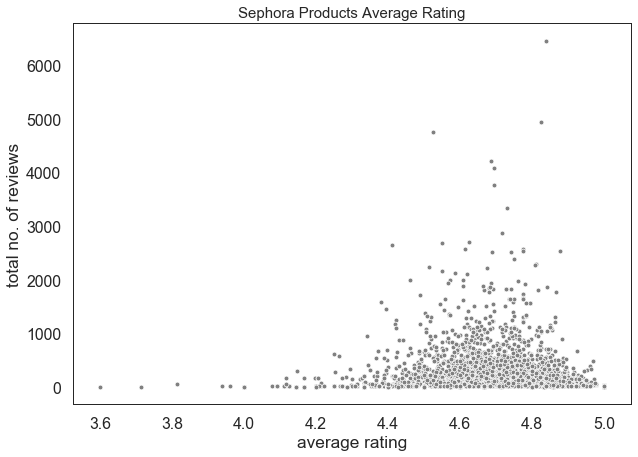

In [269]:
plt.figure(figsize=(10, 7))
sns.scatterplot("ave_rating", "total_reviews", data=product_stats_percentage,
                  color="grey")
plt.xlabel("average rating")
plt.ylabel("total no. of reviews")
plt.title("Sephora Products Average Rating", fontsize=15)
plt.show()

# reviews for the past 2 years
# where products have at least 10 reviews
# user rating >= 3
# and user recommended the product

In [270]:
product_stats_percentage.shape, product_stats_percentage.columns

((6839, 82),
 Index(['product_id', 'rating_3', 'rating_4', 'rating_5', 'age_13to17',
        'age_18to24', 'age_25to34', 'age_35to44', 'age_45to54', 'age_over54',
        'skintone_dark', 'skintone_deep', 'skintone_ebony', 'skintone_fair',
        'skintone_light', 'skintone_medium', 'skintone_olive',
        'skintone_porcelain', 'skintone_tan', 'skintype_combination',
        'skintype_dry', 'skintype_normal', 'skintype_oily', 'skinconcerns_acne',
        'skinconcerns_aging', 'skinconcerns_blackheads',
        'skinconcerns_calluses', 'skinconcerns_cellulite',
        'skinconcerns_cuticles', 'skinconcerns_darkcircles',
        'skinconcerns_dullness', 'skinconcerns_pores', 'skinconcerns_puffiness',
        'skinconcerns_redness', 'skinconcerns_sensitivity',
        'skinconcerns_stretchmarks', 'skinconcerns_sundamage',
        'skinconcerns_unevenskintones', 'eyecolor_blue', 'eyecolor_brown',
        'eyecolor_gray', 'eyecolor_green', 'eyecolor_hazel', 'haircolor_auburn',
        '

In [271]:
author_uid.shape, author_uid.columns

((608684, 2), Index(['author_id', 'uid'], dtype='object'))

# Recommender System

In [289]:
df = product_reviews[(product_reviews.product_id.isin(
    product_stats_percentage.product_id.unique()))
                     & (product_reviews.author_id.isin(
                         author_uid.author_id.unique()))].copy().drop(columns=
                             ["review_title", "review_text"])
df.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 885192 entries, 0 to 899991
Data columns (total 21 columns):
product_id            885192 non-null object
author_id             885192 non-null object
date                  885192 non-null object
review_id             885192 non-null int64
rating                885192 non-null int64
helpfulness           885192 non-null float64
feedback_count        885192 non-null int64
positive_feedback     885192 non-null int64
negative_feedback     885192 non-null int64
comment_count         885192 non-null int64
skintype              874584 non-null object
eyecolor              859153 non-null object
skinconcerns          515112 non-null object
staffcontext          613523 non-null object
haircolor             868756 non-null object
skintone              874450 non-null object
incentivizedreview    613523 non-null object
verifiedpurchaser     230775 non-null object
age                   91082 non-null object
hairconcerns          81771 non-null obj

In [291]:
del product_stats_percentage, user_stats, unique_id, author_uid_rating

In [292]:
df.fillna('0', inplace=True)

In [293]:
df = df.sort_values(["age", "skintone", "skintype", "skinconcerns", "eyecolor",
            "haircolor", "haircondition", "hairconcerns"]).copy()
df.reset_index(drop=True, inplace=True)
df

,product_id,author_id,date,review_id,rating,helpfulness,feedback_count,positive_feedback,negative_feedback,comment_count,skintype,eyecolor,skinconcerns,staffcontext,haircolor,skintone,incentivizedreview,verifiedpurchaser,age,hairconcerns,haircondition
0,P122735,23023065402,2019-09-19 21:24:08+00:00,135995852,3,2.00,0,0,0,0,0,0,0,False,0,0,True,0,0,0,0
1,P12573,1886707486,2018-11-12 04:37:45+00:00,121310090,3,2.00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,P128706,5372680671,2019-10-14 01:54:48+00:00,137239442,3,2.00,0,0,0,0,0,0,0,False,0,0,False,False,0,0,0
3,P163103,10612140468,2020-03-28 19:51:59+00:00,151499522,3,1.00,2,2,0,0,0,0,0,False,0,0,False,0,0,0,0
4,P174502,5742906597,2019-04-19 10:45:56+00:00,126741502,3,2.00,0,0,0,0,0,0,0,False,0,0,False,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
885187,P440065,2489107310,2019-03-14 18:21:42+00:00,125474925,5,2.00,0,0,0,0,oily,brown,darkCircles,False,black,tan,True,0,over54,0,0
885188,P426340,26041356151,2020-05-12 20:23:17+00:00,156235741,5,2.00,0,0,0,0,oily,brown,sunDamage,False,blonde,tan,False,0,over54,0,0
885189,P454033,26041356151,2020-06-04 05:59:22+00:00,157559217,5,2.00,0,0,0,0,oily,brown,sunDamage,False,blonde,tan,False,0,over54,0,0
885190,P433813,26041356151,2020-05-31 05:15:46+00:00,157314489,5,2.00,0,0,0,0,oily,brown,sunDamage,False,blonde,tan,False,0,over54,Volumizing,0


In [294]:
unique_id = df[df.duplicated(subset=["age", "skintone", "skintype", "skinconcerns", "eyecolor",
            "haircolor", "haircondition", "hairconcerns"], keep="first")==False].index

unique_id

Int64Index([     0,   7248,   7252,   7262,   7269,   7284,   7292,   7294,
              7296,   7302,
            ...
            885167, 885168, 885169, 885171, 885175, 885182, 885184, 885188,
            885190, 885191],
           dtype='int64', length=34749)

In [297]:
for i in tqdm(unique_id):
    df.at[i, "uid"] = "_".join(
        list(df[[
            "age", "skintone", "skintype", "skinconcerns", "eyecolor",
            "haircolor", "haircondition", "hairconcerns"
        ]].iloc[i].values))

df.uid.fillna(method="ffill", inplace=True)
df

,product_id,author_id,date,review_id,rating,helpfulness,feedback_count,positive_feedback,negative_feedback,comment_count,skintype,eyecolor,skinconcerns,staffcontext,haircolor,skintone,incentivizedreview,verifiedpurchaser,age,hairconcerns,haircondition,uid
0,P122735,23023065402,2019-09-19 21:24:08+00:00,135995852,3,2.00,0,0,0,0,0,0,0,False,0,0,True,0,0,0,0,0_0_0_0_0_0_0_0
1,P12573,1886707486,2018-11-12 04:37:45+00:00,121310090,3,2.00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0_0_0_0_0_0_0_0
2,P128706,5372680671,2019-10-14 01:54:48+00:00,137239442,3,2.00,0,0,0,0,0,0,0,False,0,0,False,False,0,0,0,0_0_0_0_0_0_0_0
3,P163103,10612140468,2020-03-28 19:51:59+00:00,151499522,3,1.00,2,2,0,0,0,0,0,False,0,0,False,0,0,0,0,0_0_0_0_0_0_0_0
4,P174502,5742906597,2019-04-19 10:45:56+00:00,126741502,3,2.00,0,0,0,0,0,0,0,False,0,0,False,0,0,0,0,0_0_0_0_0_0_0_0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
885187,P440065,2489107310,2019-03-14 18:21:42+00:00,125474925,5,2.00,0,0,0,0,oily,brown,darkCircles,False,black,tan,True,0,over54,0,0,over54_tan_oily_darkCircles_brown_black_0_0
885188,P426340,26041356151,2020-05-12 20:23:17+00:00,156235741,5,2.00,0,0,0,0,oily,brown,sunDamage,False,blonde,tan,False,0,over54,0,0,over54_tan_oily_sunDamage_brown_blonde_0_0
885189,P454033,26041356151,2020-06-04 05:59:22+00:00,157559217,5,2.00,0,0,0,0,oily,brown,sunDamage,False,blonde,tan,False,0,over54,0,0,over54_tan_oily_sunDamage_brown_blonde_0_0
885190,P433813,26041356151,2020-05-31 05:15:46+00:00,157314489,5,2.00,0,0,0,0,oily,brown,sunDamage,False,blonde,tan,False,0,over54,Volumizing,0,over54_tan_oily_sunDamage_brown_blonde_0_Volumizing


In [298]:
# df.to_csv("user_item_rating_raw.csv", index=False)

In [52]:
# del product_reviews, product_stats_percentage

In [2]:
df = pd.read_csv("user_item_rating_raw.csv")
df

/Applications/anaconda3/envs/learn-env/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (1,18,20) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,product_id,author_id,date,review_id,rating,helpfulness,feedback_count,positive_feedback,negative_feedback,comment_count,skintype,eyecolor,skinconcerns,staffcontext,haircolor,skintone,incentivizedreview,verifiedpurchaser,age,hairconcerns,haircondition,uid
0,P122735,23023065402,2019-09-19 21:24:08+00:00,135995852,3,2.0000,0,0,0,0,0,0,0,False,0,0,True,0,0,0,0,0_0_0_0_0_0_0_0
1,P12573,1886707486,2018-11-12 04:37:45+00:00,121310090,3,2.0000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0_0_0_0_0_0_0_0
2,P128706,5372680671,2019-10-14 01:54:48+00:00,137239442,3,2.0000,0,0,0,0,0,0,0,False,0,0,False,False,0,0,0,0_0_0_0_0_0_0_0
3,P163103,10612140468,2020-03-28 19:51:59+00:00,151499522,3,1.0000,2,2,0,0,0,0,0,False,0,0,False,0,0,0,0,0_0_0_0_0_0_0_0
4,P174502,5742906597,2019-04-19 10:45:56+00:00,126741502,3,2.0000,0,0,0,0,0,0,0,False,0,0,False,0,0,0,0,0_0_0_0_0_0_0_0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
885187,P440065,2489107310,2019-03-14 18:21:42+00:00,125474925,5,2.0000,0,0,0,0,oily,brown,darkCircles,False,black,tan,True,0,over54,0,0,over54_tan_oily_darkCircles_brown_black_0_0
885188,P426340,26041356151,2020-05-12 20:23:17+00:00,156235741,5,2.0000,0,0,0,0,oily,brown,sunDamage,False,blonde,tan,False,0,over54,0,0,over54_tan_oily_sunDamage_brown_blonde_0_0
885189,P454033,26041356151,2020-06-04 05:59:22+00:00,157559217,5,2.0000,0,0,0,0,oily,brown,sunDamage,False,blonde,tan,False,0,over54,0,0,over54_tan_oily_sunDamage_brown_blonde_0_0
885190,P433813,26041356151,2020-05-31 05:15:46+00:00,157314489,5,2.0000,0,0,0,0,oily,brown,sunDamage,False,blonde,tan,False,0,over54,Volumizing,0,over54_tan_oily_sunDamage_brown_blonde_0_Volumizing


In [3]:
author_ids = list(df.uid.unique())
product_ids = list(df.product_id.unique())

In [4]:
# A reader is still needed but only the rating_scale param is requiered.
reader = Reader(rating_scale=(3, 5))

In [5]:
# The columns must correspond to user id, item id and ratings (in that order).
data = Dataset.load_from_df(df[["uid", "product_id", "rating"]], reader)

In [6]:
dataset = data.build_full_trainset()
print('Number of users: ', dataset.n_users, '\n')
print('Number of items: ', dataset.n_items)

Number of users:  34749 

Number of items:  6839


In [7]:
del df

In [8]:
trainset, testset = train_test_split(data, random_state=42)

In [311]:
baseline = BaselineOnly(verbose=True)
baseline.fit(trainset)
accuracy.rmse(baseline.test(testset)), accuracy.mae(baseline.test(testset))

Estimating biases using als...
RMSE: 0.5239
MAE:  0.4213


(0.5238914471011872, 0.42132564317537485)

In [313]:
knn_base = KNNBaseline(verbose=True)
knn_base.fit(trainset)
accuracy.rmse(knn_base.test(testset)), accuracy.mae(knn_base.test(testset))

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.5341
MAE:  0.3991


(0.5341034194390785, 0.39906235232037407)

In [9]:
knn_base2 = KNNBaseline(sim_options={'name':'pearson', 'user_based':True}, verbose=True)
knn_base2.fit(trainset)
accuracy.rmse(knn_base2.test(testset)), accuracy.mae(knn_base2.test(testset))

Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.5463
MAE:  0.4146


(0.546319145685738, 0.41462871467531964)

In [11]:
knn_base3 = KNNBaseline(sim_options={'name':'pearson_baseline', 'user_based':True}, verbose=True)
knn_base3.fit(trainset)
accuracy.rmse(knn_base3.test(testset)), accuracy.mae(knn_base3.test(testset))

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.5504
MAE:  0.4159


(0.5504256515482122, 0.4159216830132572)

In [12]:
knn_base4 = KNNBaseline(sim_options={'name':'cosine', 'user_based':True}, verbose=True)
knn_base4.fit(trainset)
accuracy.rmse(knn_base4.test(testset)), accuracy.mae(knn_base4.test(testset))

Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.5327
MAE:  0.4096


(0.5327086336791373, 0.40955679646761245)

In [314]:
knn_basic = KNNBasic(verbose=True)
knn_basic.fit(trainset)
accuracy.rmse(knn_basic.test(testset)), accuracy.mae(knn_basic.test(testset))

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.5366
MAE:  0.3927


(0.5365941508492791, 0.39273999839571455)

In [14]:
knn_basic2 = KNNBasic(sim_options={'name':'pearson', 'user_based':True}, verbose=True)
knn_basic2.fit(trainset)
accuracy.rmse(knn_basic2.test(testset)), accuracy.mae(knn_basic2.test(testset))

Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.5479
MAE:  0.4197


(0.5479107022760707, 0.41969268964304485)

In [15]:
knn_basic3 = KNNBasic(sim_options={'name':'cosine', 'user_based':True}, verbose=True)
knn_basic3.fit(trainset)
accuracy.rmse(knn_basic3.test(testset)), accuracy.mae(knn_basic3.test(testset))

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.5351
MAE:  0.4053


(0.5351464396133162, 0.40531702256293123)

In [312]:
svd_base = SVD(verbose=True)
svd_base.fit(trainset)
accuracy.rmse(svd_base.test(testset)), accuracy.mae(svd_base.test(testset))

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
RMSE: 0.5274
MAE:  0.4196


(0.5273920617140608, 0.419596322927952)

In [307]:
svdpp_base = SVDpp(verbose=True)
svdpp_base.fit(trainset)
accuracy.rmse(svdpp_base.test(testset)), accuracy.mae(svdpp_base.test(testset))

 processing epoch 0
 processing epoch 1
 processing epoch 2
 processing epoch 3
 processing epoch 4
 processing epoch 5
 processing epoch 6
 processing epoch 7
 processing epoch 8
 processing epoch 9
 processing epoch 10
 processing epoch 11
 processing epoch 12
 processing epoch 13
 processing epoch 14
 processing epoch 15
 processing epoch 16
 processing epoch 17
 processing epoch 18
 processing epoch 19
RMSE: 0.5265
MAE:  0.4189


(0.5264597133339708, 0.41887865780918776)

In [316]:
nmf_base = NMF(verbose=True)
nmf_base.fit(trainset)
accuracy.rmse(nmf_base.test(testset)), accuracy.mae(nmf_base.test(testset))

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Processing epoch 20
Processing epoch 21
Processing epoch 22
Processing epoch 23
Processing epoch 24
Processing epoch 25
Processing epoch 26
Processing epoch 27
Processing epoch 28
Processing epoch 29
Processing epoch 30
Processing epoch 31
Processing epoch 32
Processing epoch 33
Processing epoch 34
Processing epoch 35
Processing epoch 36
Processing epoch 37
Processing epoch 38
Processing epoch 39
Processing epoch 40
Processing epoch 41
Processing epoch 42
Processing epoch 43
Processing epoch 44
Processing epoch 45
Processing epoch 46
Processing epoch 47
Processing epoch 48
Processing epoch 49
RMSE: 0.60

(0.6028813089661968, 0.5387184622565389)

In [318]:
coclustering_base = CoClustering(verbose=True)
coclustering_base.fit(trainset)
accuracy.rmse(coclustering_base.test(testset)), accuracy.mae(coclustering_base.test(testset))

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
RMSE: 0.5347
MAE:  0.4178


(0.5347420697444434, 0.4178475037704079)

In [319]:
benchmark = []
# Iterate over all algorithms
for algorithm in tqdm([BaselineOnly(), SVD(), KNNBaseline()]):
    # Perform cross validation
    results = cross_validate(algorithm,
                             data,
                             measures=['RMSE', 'MAE'],
                             cv=5,
                             verbose=False)

    # Get results & append algorithm name
    results_table = pd.DataFrame.from_dict(results).mean(axis=0)
    results_table = results_table.append(
        pd.Series([str(algorithm).split(' ')[0].split('.')[-1]],
                  index=['Algorithm']))
    benchmark.append(results_table)

cv_results = pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.



In [320]:
cv_results

,test_rmse,test_mae,fit_time,test_time
Algorithm,,,,
BaselineOnly,0.52,0.42,3.06,1.24
SVD,0.53,0.42,38.13,1.37
KNNBaseline,0.53,0.40,96.49,104.64


In [9]:
params = {
    'n_factors': [50, 100],
    'reg_all': [0.02, 0.05, 0.1],
    'lr_all': [0.001, 0.01]
}
gs_SVD = GridSearchCV(SVD, param_grid=params, n_jobs=1, cv=5,  joblib_verbose=1)

In [10]:
gs_SVD.fit(data)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed: 32.3min finished


In [13]:
gs_SVD.best_score

{'rmse': 0.523895969841283, 'mae': 0.41681492900426986}

In [14]:
gs_SVD.best_params

{'rmse': {'n_factors': 50, 'reg_all': 0.1, 'lr_all': 0.001},
 'mae': {'n_factors': 100, 'reg_all': 0.02, 'lr_all': 0.01}}

In [33]:
pd.DataFrame(gs_SVD.cv_results)[[
    "rank_test_rmse", "mean_test_rmse", "std_test_rmse", "rank_test_mae",
    "mean_test_mae", "std_test_mae", "mean_fit_time", "mean_test_time",
    "params"
]].sort_values("rank_test_rmse")

,rank_test_rmse,mean_test_rmse,std_test_rmse,rank_test_mae,mean_test_mae,std_test_mae,mean_fit_time,mean_test_time,params
4,1,0.5239,0.0013,11,0.4243,0.0008,25.9656,2.0926,"{'n_factors': 50, 'reg_all': 0.1, 'lr_all': 0.001}"
2,2,0.5244,0.0013,9,0.4235,0.0008,20.5780,1.7647,"{'n_factors': 50, 'reg_all': 0.05, 'lr_all': 0.001}"
10,3,0.5245,0.0013,12,0.4244,0.0007,37.7642,2.0064,"{'n_factors': 100, 'reg_all': 0.1, 'lr_all': 0.001}"
0,4,0.5251,0.0014,7,0.4229,0.0008,22.0384,2.0167,"{'n_factors': 50, 'reg_all': 0.02, 'lr_all': 0.001}"
8,5,0.5253,0.0014,10,0.4235,0.0007,40.2707,2.2490,"{'n_factors': 100, 'reg_all': 0.05, 'lr_all': 0.001}"
11,6,0.5255,0.0014,6,0.4198,0.0013,36.4845,1.9912,"{'n_factors': 100, 'reg_all': 0.1, 'lr_all': 0.01}"
5,7,0.5255,0.0014,5,0.4198,0.0013,24.0591,2.1955,"{'n_factors': 50, 'reg_all': 0.1, 'lr_all': 0.01}"
9,8,0.5256,0.0014,3,0.4186,0.0013,40.1913,2.2276,"{'n_factors': 100, 'reg_all': 0.05, 'lr_all': 0.01}"
3,9,0.5256,0.0014,4,0.4187,0.0014,20.7437,2.0051,"{'n_factors': 50, 'reg_all': 0.05, 'lr_all': 0.01}"
6,10,0.5271,0.0014,8,0.4233,0.0009,33.2322,1.8142,"{'n_factors': 100, 'reg_all': 0.02, 'lr_all': 0.001}"


In [39]:
params = {
    'n_factors': [20, 50, 100],
    'reg_all': [0.1, 0.5, 0.7],
    'lr_all': [0.001, 0.01, 0.1]
}
gs_SVD = GridSearchCV(SVD, param_grid=params, n_jobs=1, cv=5, joblib_verbose=1)

In [40]:
gs_SVD.fit(data)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 135 out of 135 | elapsed: 60.5min finished


In [41]:
gs_SVD.best_params["rmse"]

{'n_factors': 20, 'reg_all': 0.1, 'lr_all': 0.001}

In [43]:
pd.DataFrame(gs_SVD.cv_results)[[
    "rank_test_rmse", "mean_test_rmse", "std_test_rmse", "rank_test_mae",
    "mean_test_mae", "std_test_mae", "mean_fit_time", "mean_test_time",
    "params"
]].sort_values("rank_test_rmse").head(5)

,rank_test_rmse,mean_test_rmse,std_test_rmse,rank_test_mae,mean_test_mae,std_test_mae,mean_fit_time,mean_test_time,params
0,1,0.5235,0.0011,13,0.4244,0.0005,15.5798,1.8214,"{'n_factors': 20, 'reg_all': 0.1, 'lr_all': 0.001}"
9,2,0.5238,0.0010,14,0.4244,0.0004,22.3399,1.7329,"{'n_factors': 50, 'reg_all': 0.1, 'lr_all': 0.001}"
3,3,0.5242,0.0010,22,0.4290,0.0004,15.1136,1.8110,"{'n_factors': 20, 'reg_all': 0.5, 'lr_all': 0.001}"
12,4,0.5243,0.0010,24,0.4290,0.0004,23.4584,1.7964,"{'n_factors': 50, 'reg_all': 0.5, 'lr_all': 0.001}"
21,5,0.5244,0.0010,23,0.4290,0.0004,36.9644,1.9160,"{'n_factors': 100, 'reg_all': 0.5, 'lr_all': 0.001}"


## Best SVD Model

In [9]:
algo = SVD(n_factors =20, reg_all = 0.1, lr_all = 0.001)
algo.fit(trainset)

In [11]:
accuracy.rmse(algo.test(testset)), accuracy.mae(algo.test(testset))

RMSE: 0.5242
MAE:  0.4246


(0.5242208346762557, 0.42459001748927466)

In [111]:
# pickle.dump(algo, open("SVD_best.pkl", "wb"))
# algo = pickle.load(open("SVD_best.pkl", "rb"))

In [112]:
def get_topn(uid, product_ids, n=50):
    
    algo=pickle.load(open("SVD_best.pkl", "rb"))
    
    items_to_pred = [(uid, iid, 0) for iid in product_ids]
    
    predictions = algo.test(items_to_pred)
    
    item_predictions = pd.DataFrame({
        "iid": product_ids,
        "est": [pred.est for pred in predictions]
    }).sort_values("est", ascending=False).reset_index(drop=True)
    
    
    return item_predictions.head(n)

In [13]:
def age_range(age):

    age_dict = {
        "13to17": range(1, 17 + 1),
        "18to24": range(18, 24 + 1),
        "25to34": range(25, 34 + 1),
        "35to44": range(35, 44 + 1),
        "45to54": range(45, 54 + 1),
        "over54": range(54, 100 + 1),
        "0": [0]
    }

    if age > 100:
        print("please check age input")
        return

    for key, val in age_dict.items():
        if age in val:
            age_group = key
            if age < 13:
                print("products may not be aged appropriate")
            return age_group

In [16]:
age = 36 
ager = age_range(age)
stone = "medium" # 'light' 'medium' 'fair' 'ebony' 'olive' 'deep' 'dark' 'tan' 'porcelain'
stype = "0" # 'combination' 'oily' 'normal' 'dry'
sconcerns = "aging" # 'acne' 'aging' 'blackheads' 'unevenSkinTones' 'sensitivity' 
# 'darkCircles' 'calluses' 'pores' 'redness' 'dullness' 'cellulite'
# 'sunDamage' 'cuticles' 'stretchMarks' 'puffiness'
ecolor = "brown" # 'green' 'blue' 'brown' 'hazel' 'gray'
hcolor = "0" # brunette' 'black' 'red' 'blonde' 'gray' 'auburn'
hcondition = "0" #'chemicallyTreated' 'normal' 'wavy' 'fine' 'curly' 'coarse' 'dry'
# 'oily' 'straight'
hconcerns = "0"# 'ColorProtection' 'Damage' 'CurlyEnhancing' 'Dandruff' 'Volumizing'
#  'AntiAging' 'Frizz' 'Hold' 'Thinning' 'Oiliness' 'StraighteningSmoothing'
#  'HeatProtection' 'Shine'

budget_low = 50
budget_max = 100

uid_query=ager+"_"+stone+"_"+stype+"_"+sconcerns+"_"+ecolor+"_"+hcolor+"_"+hcondition+"_"+hconcerns.title()
uid_query

'35to44_medium_0_aging_brown_0_0_0'

In [40]:
items_to_pred = [[uid_query, iid, np.nan] for iid in product_ids]
predictions = algo.test(items_to_pred)
pred_ratings = np.array([pred.est for pred in predictions])

# map rating preds to product id
top_products = pd.DataFrame(data=pred_ratings,
                            columns=["pred_ratings"],
                            index=product_ids).sort_values(
                                "pred_ratings",
                                ascending=False).reset_index().head(500)

# get product details
top_products = pd.merge(top_products,
                        products,
                        how="left",
                        left_on="index",
                        right_on="id")

del items_to_pred, pred_ratings, predictions

top_products = top_products[(top_products.price_low >= budget_low)
                            & (top_products.price_high <= budget_max)]
top_products.sort_values(
    ["pred_ratings", "rating", "review_count"], ascending=False).head(15).drop(
        columns=["long_desc", "brand_long", "ingredients", "suggested_usage"])

,index,pred_ratings,id,name,brand_id,brand_name,short_desc,item,item_name,list_price,variation,variants,price_low,price_high,is_limited_edition,rating,review_count,user_favorites,categories,url,image_url,has_variants,has_categories,has_ingredients,has_suggested_usage,is_rated,cologne,men,fragrance,perfume,women,lotions_and_oils,rollerballs_and_travel_size,perfume_gift_sets,value_and_gift_sets,lipstick,lip,makeup,lip_balms_and_treatments,lip_treatments,mascara,eye,lip_gloss,eyebrow,body_sprays_and_deodorant,bath_and_shower,cologne_gift_sets,body_mist_and_hair_mist,concealer,face,lip_stain,deodorant_and_antiperspirant,body_care,bath_and_body,face_primer,foundation,tinted_moisturizer,face_serums,treatments,skincare,mists_and_essences,moisturizers,highlighter,liquid_lipstick,lip_sets,face_sets,setting_spray_and_powder,aftershave,shaving,eye_creams_and_treatments,eye_care,face_masks,masks,face_wash_and_cleansers,cleansers,exfoliators,makeup_removers,eyeliner,face_brushes,makeup_brushes_and_applicators,makeup_palettes,eye_palettes,bb_and_cc_creams,blush,cheek,facial_peels,eyelash_curlers,accessories,eye_sets,mini_size,bronzer,face_oils,contour,lip_liner,eyeshadow,face_wash,moisturizer_and_treatments,toners,body_lotions_and_body_oils,body_moisturizers,scrub_and_exfoliants,self_tanners,face_sunscreen,sun_care,blemish_and_acne_treatments,facial_cleansing_brushes,high_tech_tools,for_face,color_correct,skincare_sets,decollete_and_neck_creams,hand_cream_and_foot_cream,candles_and_home_scents,night_creams,sheet_masks,eye_brushes,beauty_supplements,wellness,facial_rollers,body_sunscreen,cellulite_and_stretch_marks,for_body,body_wash_and_shower_gel,nail,other_needs,shampoo_and_conditioner,hair,hair_styling_and_treatments,conditioner,shampoo,eye_masks,eye_primer,mirrors_and_sharpeners,tools_and_brushes,cheek_palettes,face_wipes,tweezers_and_eyebrow_tools,hair_accessories,hair_tools,gift_cards,false_eyelashes,brush_sets,brush_cleaners,makeup_and_travel_cases,hair_removal,lip_brushes,sponges_and_applicators,makeup_bags_and_travel_cases,hair_masks,curling_irons,hair_straighteners_and_flat_irons,hair_dryers,dry_shampoo,hair_brushes_and_combs,scalp_and_hair_treatments,bath_soaks_and_bubble_bath,hair_styling_products,blotting_papers,hair_primers,hair_oil,teeth_whitening,anti_aging,travel_size,facial_men,candles,diffusers,holistic_wellness,leave_in_conditioner,hair_spray,color_care,best_for,just_arrived,gifts_her,gifts_men,gifts_them,gifts_teens,gift_sets_men,gift_sets,editors_picks,luxury_gifts,sephora_exclusives,perfume_men,grooming_men,hair_men,personal_care_men,just_arrived_men,best_seller_men,vegan,cruelty_free,for_men
1,P459127,4.9357,P459127,Platinum Lip Plump SPF 30,6318,Dr. Lara Devgan Scientific Beauty,A lip plumper that improve the smoothness and hydration of the lips in the form of a clear gloss.,2374049,0.10 oz/ 3 mL,50.0000,None,NaN,50.0000,50.0000,0,4.9109,505,2652,"{'cat60109': 'Lip Balms & Treatments', 'cat1520035': 'Lip Treatments', 'cat150006': 'Skincare'}",https://www.sephora.com/product/dr-lara-devgan-scientific-beauty-platinum-lip-plump-P459127?skuId=2374049,https://www.sephora.com/productimages/sku/s2374049-main-zoom.jpg,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0
3,P444401,4.9292,P444401,Solstice Eyeshadow Palette,6276,Aether Beauty,"A palette of 12 golden hour shades in matte, shimmer, satin, metallic, and duo-chrome finishes to have your eyes glowing like a sunset.",2189975,NaN,58.0000,None,NaN,58.0000,58.0000,0,4.9091,143,8835,"{'cat60045': 'Eye Palettes', 'cat130054': 'Eye', 'cat140006': 'Makeup'}",https://www.sephora.com/product/summer-solstice-eyeshadow-palette-P444401?skuId=2189975,https://www.sephora.com/productimages/sku/s218997

In [18]:
pred_ratings

array([4.69556888, 4.90271872, 4.62192093, ..., 4.72897518, 4.782293  ,
       4.73884306])

In [19]:
top_products = pd.DataFrame(data=pred_ratings, columns=["pred_ratings"],
             index=product_ids).sort_values("pred_ratings",ascending=False).reset_index().head(500)
top_products = pd.merge(top_products, products, how="left", left_on="index", right_on="id").sort_values(["pred_ratings","list_price"],ascending=False)
del items_to_pred, pred_ratings, predictions
top_products

,index,pred_ratings,id,name,brand_id,brand_name,short_desc,long_desc,item,item_name,list_price,variation,variants,price_low,price_high,is_limited_edition,rating,review_count,user_favorites,categories,url,image_url,ingredients,suggested_usage,brand_long,has_variants,has_categories,has_ingredients,has_suggested_usage,is_rated,cologne,men,fragrance,perfume,women,lotions_and_oils,rollerballs_and_travel_size,perfume_gift_sets,value_and_gift_sets,lipstick,lip,makeup,lip_balms_and_treatments,lip_treatments,mascara,eye,lip_gloss,eyebrow,body_sprays_and_deodorant,bath_and_shower,cologne_gift_sets,body_mist_and_hair_mist,concealer,face,lip_stain,deodorant_and_antiperspirant,body_care,bath_and_body,face_primer,foundation,tinted_moisturizer,face_serums,treatments,skincare,mists_and_essences,moisturizers,highlighter,liquid_lipstick,lip_sets,face_sets,setting_spray_and_powder,aftershave,shaving,eye_creams_and_treatments,eye_care,face_masks,masks,face_wash_and_cleansers,cleansers,exfoliators,makeup_removers,eyeliner,face_brushes,makeup_brushes_and_applicators,makeup_palettes,eye_palettes,bb_and_cc_creams,blush,cheek,facial_peels,eyelash_curlers,accessories,eye_sets,mini_size,bronzer,face_oils,contour,lip_liner,eyeshadow,face_wash,moisturizer_and_treatments,toners,body_lotions_and_body_oils,body_moisturizers,scrub_and_exfoliants,self_tanners,face_sunscreen,sun_care,blemish_and_acne_treatments,facial_cleansing_brushes,high_tech_tools,for_face,color_correct,skincare_sets,decollete_and_neck_creams,hand_cream_and_foot_cream,candles_and_home_scents,night_creams,sheet_masks,eye_brushes,beauty_supplements,wellness,facial_rollers,body_sunscreen,cellulite_and_stretch_marks,for_body,body_wash_and_shower_gel,nail,other_needs,shampoo_and_conditioner,hair,hair_styling_and_treatments,conditioner,shampoo,eye_masks,eye_primer,mirrors_and_sharpeners,tools_and_brushes,cheek_palettes,face_wipes,tweezers_and_eyebrow_tools,hair_accessories,hair_tools,gift_cards,false_eyelashes,brush_sets,brush_cleaners,makeup_and_travel_cases,hair_removal,lip_brushes,sponges_and_applicators,makeup_bags_and_travel_cases,hair_masks,curling_irons,hair_straighteners_and_flat_irons,hair_dryers,dry_shampoo,hair_brushes_and_combs,scalp_and_hair_treatments,bath_soaks_and_bubble_bath,hair_styling_products,blotting_papers,hair_primers,hair_oil,teeth_whitening,anti_aging,travel_size,facial_men,candles,diffusers,holistic_wellness,leave_in_conditioner,hair_spray,color_care,best_for,just_arrived,gifts_her,gifts_men,gifts_them,gifts_teens,gift_sets_men,gift_sets,editors_picks,luxury_gifts,sephora_exclusives,perfume_men,grooming_men,hair_men,personal_care_men,just_arrived_men,best_seller_men,vegan,cruelty_free,for_men
0,P433886,4.9981,P433886,Squalane + Glycolic Renewal Mask,6195,Biossance,"A triple-change peel, exfoliator, and mask in one skin-renewing, smoothing, and hydrating formula.","What it is: A triple-change peel, exfoliator, and mask in one skin-renewing, smoothing, and hydrating formula. Skin Type: Normal, Dry, Combination, and Oily Skincare Concerns: Dullness and uneven texture, pores, and oiliness Formulation: Mask Highlighted Ingredients: - Bilberry, Sugar Cane, and Sugar Maple Extracts: Naturally-derived AHAs. - Glycolic, Lactic, Tartaric, Malic Acids (AHA): AHAs that help Helps shed dead skin cells, support natural cell turnover and refine the skin's surface. - Squalane: Hydrates while locking in essential moisture. Ingredient Callouts: This product is also vegan, cruelty-free, and gluten-free. What Else You Need to Know: Glycolic and multi-alpha hydroxy acids visibly brighten, while gentle mineral spheres gently polish and smooth skin. Squalane and hyaluronic acid plump and hydrate the look of skin. The look of fine lines, discoloration, enlarged pores, and other imperfections are diminished. Clinical Results: Based on a 1-use clinical study of 31 women aged 30 to 60, once daily use: - 100% saw an improvement in overall skin texture. - 97% agree that their skin looked instantly 

In [240]:
uid = author_ids[56]

items_to_pred = [[uid, iid, 0] for iid in product_ids]
predictions = svd_base.test(items_to_pred)
pred_ratings = np.array([pred.est for pred in predictions])

In [247]:
top_products = pd.DataFrame(data=pred_ratings, columns=["pred_ratings"],
             index=product_ids).sort_values("pred_ratings",ascending=False).reset_index().head(500)
top_products = pd.merge(top_products, products, how="left", left_on="index", right_on="id").sort_values(["pred_ratings","list_price"],ascending=False)
del items_to_pred, pred_ratings, predictions
top_products

,index,pred_ratings,id,name,brand_id,brand_name,short_desc,long_desc,item,item_name,list_price,variation,variants,price_low,price_high,is_limited_edition,is_natural_organic,rating,review_count,user_favorites,categories,url,image_url,ingredients,suggested_usage,brand_long,has_variants,has_categories,has_ingredients,has_suggested_usage,is_rated,cologne,men,fragrance,perfume,women,lotions_and_oils,rollerballs_and_travel_size,perfume_gift_sets,value_and_gift_sets,lipstick,lip,makeup,lip_balms_and_treatments,lip_treatments,mascara,eye,lip_gloss,eyebrow,body_sprays_and_deodorant,bath_and_shower,cologne_gift_sets,body_mist_and_hair_mist,concealer,face,lip_stain,deodorant_and_antiperspirant,body_care,bath_and_body,face_primer,foundation,tinted_moisturizer,face_serums,treatments,skincare,mists_and_essences,moisturizers,highlighter,liquid_lipstick,lip_sets,face_sets,setting_spray_and_powder,aftershave,shaving,eye_creams_and_treatments,eye_care,face_masks,masks,face_wash_and_cleansers,cleansers,exfoliators,makeup_removers,eyeliner,face_brushes,makeup_brushes_and_applicators,makeup_palettes,eye_palettes,bb_and_cc_creams,blush,cheek,facial_peels,eyelash_curlers,accessories,eye_sets,mini_size,bronzer,face_oils,contour,lip_liner,eyeshadow,face_wash,moisturizer_and_treatments,toners,body_lotions_and_body_oils,body_moisturizers,scrub_and_exfoliants,self_tanners,face_sunscreen,sun_care,blemish_and_acne_treatments,facial_cleansing_brushes,high_tech_tools,for_face,color_correct,skincare_sets,decollete_and_neck_creams,hand_cream_and_foot_cream,candles_and_home_scents,night_creams,sheet_masks,eye_brushes,beauty_supplements,wellness,facial_rollers,body_sunscreen,cellulite_and_stretch_marks,for_body,body_wash_and_shower_gel,nail,other_needs,shampoo_and_conditioner,hair,hair_styling_and_treatments,conditioner,shampoo,eye_masks,eye_primer,mirrors_and_sharpeners,tools_and_brushes,cheek_palettes,face_wipes,tweezers_and_eyebrow_tools,hair_accessories,hair_tools,gift_cards,false_eyelashes,brush_sets,brush_cleaners,makeup_and_travel_cases,hair_removal,lip_brushes,sponges_and_applicators,makeup_bags_and_travel_cases,hair_masks,curling_irons,hair_straighteners_and_flat_irons,hair_dryers,dry_shampoo,hair_brushes_and_combs,scalp_and_hair_treatments,bath_soaks_and_bubble_bath,hair_styling_products,blotting_papers,hair_primers,hair_oil,teeth_whitening,anti_aging,travel_size,facial_men,candles,diffusers,holistic_wellness,leave_in_conditioner,hair_spray,color_care,best_for,just_arrived,gifts_her,gifts_men,gifts_them,gifts_teens,gift_sets_men,gift_sets,editors_picks,luxury_gifts,sephora_exclusives,perfume_men,grooming_men,hair_men,personal_care_men,just_arrived_men,best_seller_men,for_men,cruelty_free,vegan
0,P454055,4.97,P454055,Liquid Glass Smoothing Conditioner,7004,Drybar,"A rich formula that leaves hair manageable and soft while providing a smooth, shiny, and frizz-free finish.","What it is: A rich formula that leaves hair manageable and soft while providing a smooth, shiny, and frizz-free finish. Hair Type: Straight, Wavy, Curly, and Coily Hair Texture: Fine, Medium, and Thick Key Benefits: Hydrates, Fights Frizz, and Straightens and Smooths Formulation: Rich Cream Highlighted Ingredients: - Murumuru Butter: Helps soften and improve hair manageability without weighing it down. - Neroli Oil: Smooths, helps prevent frizz, and provides a high-shine, glossy finish. - Vegan Keratin: Helps support and smooth the hair cuticles. Ingredient Callouts: Free of sulfates SLS and SLES and parabens. This product is also vegan, cruelty-free, and gluten-free. What Else You Need to Know: This rich, smoothing conditioner is great for all hair types. It is formulated with murumuru butter, neroli oil, and vegan keratin to help soften, smooth, and moisturize hair, leaving a shiny and frizz-free look. It also features Drybar's Blanc scent with notes of coconut, amber, and vanilla.",2316750,8.5 oz/ 250 mL,26.00,None,NaN,26.00,26.00,0,0,4.64,25,3399,"{'cat60131': 'Conditioner', 'cat12

In [250]:
# price_high = 200
# price_floor = 50
# luxury_gifts_only = 1
# for_him = 1
# vegan = 1
# cruelty_free
# limited_edition

# top_products[(top_products.list_price > price_floor)
#         & (top_products.list_price < price_high)].sort_values(["pred_ratings", "list_price"], ascending=False)

In [253]:
products[products.is_natural_organic==1]

,id,name,brand_id,brand_name,short_desc,long_desc,item,item_name,list_price,variation,variants,price_low,price_high,is_limited_edition,is_natural_organic,rating,review_count,user_favorites,categories,url,image_url,ingredients,suggested_usage,brand_long,has_variants,has_categories,has_ingredients,has_suggested_usage,is_rated,cologne,men,fragrance,perfume,women,lotions_and_oils,rollerballs_and_travel_size,perfume_gift_sets,value_and_gift_sets,lipstick,lip,makeup,lip_balms_and_treatments,lip_treatments,mascara,eye,lip_gloss,eyebrow,body_sprays_and_deodorant,bath_and_shower,cologne_gift_sets,body_mist_and_hair_mist,concealer,face,lip_stain,deodorant_and_antiperspirant,body_care,bath_and_body,face_primer,foundation,tinted_moisturizer,face_serums,treatments,skincare,mists_and_essences,moisturizers,highlighter,liquid_lipstick,lip_sets,face_sets,setting_spray_and_powder,aftershave,shaving,eye_creams_and_treatments,eye_care,face_masks,masks,face_wash_and_cleansers,cleansers,exfoliators,makeup_removers,eyeliner,face_brushes,makeup_brushes_and_applicators,makeup_palettes,eye_palettes,bb_and_cc_creams,blush,cheek,facial_peels,eyelash_curlers,accessories,eye_sets,mini_size,bronzer,face_oils,contour,lip_liner,eyeshadow,face_wash,moisturizer_and_treatments,toners,body_lotions_and_body_oils,body_moisturizers,scrub_and_exfoliants,self_tanners,face_sunscreen,sun_care,blemish_and_acne_treatments,facial_cleansing_brushes,high_tech_tools,for_face,color_correct,skincare_sets,decollete_and_neck_creams,hand_cream_and_foot_cream,candles_and_home_scents,night_creams,sheet_masks,eye_brushes,beauty_supplements,wellness,facial_rollers,body_sunscreen,cellulite_and_stretch_marks,for_body,body_wash_and_shower_gel,nail,other_needs,shampoo_and_conditioner,hair,hair_styling_and_treatments,conditioner,shampoo,eye_masks,eye_primer,mirrors_and_sharpeners,tools_and_brushes,cheek_palettes,face_wipes,tweezers_and_eyebrow_tools,hair_accessories,hair_tools,gift_cards,false_eyelashes,brush_sets,brush_cleaners,makeup_and_travel_cases,hair_removal,lip_brushes,sponges_and_applicators,makeup_bags_and_travel_cases,hair_masks,curling_irons,hair_straighteners_and_flat_irons,hair_dryers,dry_shampoo,hair_brushes_and_combs,scalp_and_hair_treatments,bath_soaks_and_bubble_bath,hair_styling_products,blotting_papers,hair_primers,hair_oil,teeth_whitening,anti_aging,travel_size,facial_men,candles,diffusers,holistic_wellness,leave_in_conditioner,hair_spray,color_care,best_for,just_arrived,gifts_her,gifts_men,gifts_them,gifts_teens,gift_sets_men,gift_sets,editors_picks,luxury_gifts,sephora_exclusives,perfume_men,grooming_men,hair_men,personal_care_men,just_arrived_men,best_seller_men,for_men,cruelty_free,vegan
7512,P441803,Rose Quartz Crystal Gemstone Eyeshadow Palette,6276,Aether Beauty,"A palette with 12 shades infused with rose quartz in ultra-matte, shimmer, duo-chrome, and metallic finishes that let you create softly-glamourous looks anytime.","What it is: A palette with 12 shades infused with rose quartz in ultra-matte, shimmer, duo-chrome, and metallic finishes that let you create softly-glamourous looks anytime. Highlighted Ingredients: - Organic* and Fair Trade** Coconut Oil: Creates a buttery-smooth texture. - Rose Quartz Gemstone Powder: Helps diminish the look of wrinkles, redness, and fine lines. - Organic* Rose Hip Oil: Supports radiant-looking, glowing skin. Ingredient Callouts: This product is vegan, cruelty-free, and gluten-free, and comes in recyclable packaging. What Else You Need to Know: These shades are formulated with coconut oil and shea butter to create an ber-smooth, buttery texture for one swipe application. Rose quartz powder helps to reduce the appearance of fine lines, wrinkles, and redness while illuminating the skin with its light-reflective crystals. This palette is sustainably packaged. After removing the eyeshadow pans and elastic, this paper palette is fully recyclable and zero-waste the first of its kind in the industry. This Palette Contains: - 8 x 0

In [65]:
# params = {'n_factors': [10, 20],
#          'reg_all': [0.02, 0.05, 0.1]}
# g_s_svd = GridSearchCV(SVD,param_grid=params,n_jobs=-1)
# g_s_svd.fit(data)

In [66]:
# print(g_s_svd.best_score)
# print(g_s_svd.best_params)

{'rmse': 0.5054657555809845, 'mae': 0.40274002386004976}
{'rmse': {'n_factors': 100, 'reg_all': 0.1}, 'mae': {'n_factors': 100, 'reg_all': 0.02}}


In [23]:
# # cross validating with KNNBasic
# knn_basic = KNNBasic(sim_options={'name':'pearson', 'user_based':True})
# cv_knn_basic = cross_validate(knn_basic, data, n_jobs=-1)

In [24]:
# for i in cv_knn_basic.items():
#     print(i)
# print('-----------------------')
# print(np.mean(cv_knn_basic['test_rmse']))

('test_rmse', array([0.70393981, 0.64575537, 0.63692744, 0.63023805, 0.60506327]))
('test_mae', array([0.56725  , 0.5367   , 0.5322125, 0.5274   , 0.515375 ]))
('fit_time', (0.04223513603210449, 0.043650150299072266, 0.04364800453186035, 0.04182720184326172, 0.027640104293823242))
('test_time', (0.0015630722045898438, 0.0014960765838623047, 0.0014078617095947266, 0.0014140605926513672, 0.001444101333618164))
-----------------------
0.6443847876024148


In [25]:
# # cross validating with KNNBaseline
# knn_baseline = KNNBaseline(sim_options={'name':'pearson', 'user_based':True})
# cv_knn_baseline = cross_validate(knn_baseline,data)

Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.


In [26]:
# for i in cv_knn_baseline.items():
#     print(i)

# np.mean(cv_knn_baseline['test_rmse'])

('test_rmse', array([0.63801205, 0.67060225, 0.68617023, 0.58904827, 0.66799372]))
('test_mae', array([0.52375997, 0.55111163, 0.54940623, 0.50025351, 0.55021826]))
('fit_time', (0.05592989921569824, 0.0341486930847168, 0.048558712005615234, 0.03869795799255371, 0.033309221267700195))
('test_time', (0.0018079280853271484, 0.0012211799621582031, 0.0014290809631347656, 0.001332998275756836, 0.0012969970703125))


0.6503653046223841